# Segregación de notas de un archivo de audio

El siguiente notebook tiene como objetivo demostrar que es posible segregar en multiples ficheros de audio una grabación musical para detectar diferentes acordes.

Me he inspirado en el siguiente artículo que tiene un ejemplo para detectar las notas en una grabación de audio de trompeta: https://www.educative.io/answers/how-to-perform-note-tracking-in-librosa

Otro artículo útil ha sido el de Audio Professing using Librosa for Begfinners: https://www.kaggle.com/code/jaseemck/audio-processing-using-librosa-for-beginners

Para ello utilizaremos la libreria de **librosa** de python intentando detectar segmentos utilizando silencios y cambios de pitch


## 1. Importar helper functions
Empezaremos importando una libreria propia en python con helper functions : https://github.com/lferrerraventos/SoundToTabsTensorFlow/blob/main/notebooks/helpers/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/lferrerraventos/SoundToTabsTensorFlow/main/notebooks/helpers/helper_functions.py

--2024-05-08 15:51:52--  https://raw.githubusercontent.com/lferrerraventos/SoundToTabsTensorFlow/main/notebooks/helpers/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6051 (5.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   5.91K  --.-KB/s    in 0s      

2024-05-08 15:51:52 (35.4 MB/s) - ‘helper_functions.py’ saved [6051/6051]



In [3]:
from helper_functions import  create_spectrogram, unzip_data

## 2. Descargar audio

Descargamos una corta grabación de guitarra

In [1]:
!wget https://github.com/lferrerraventos/SoundToTabsTensorFlow/raw/main/datasets/song_to_test1.wav

--2024-05-08 15:51:51--  https://github.com/lferrerraventos/SoundToTabsTensorFlow/raw/main/datasets/song_to_test1.wav
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lferrerraventos/SoundToTabsTensorFlow/main/datasets/song_to_test1.wav [following]
--2024-05-08 15:51:51--  https://raw.githubusercontent.com/lferrerraventos/SoundToTabsTensorFlow/main/datasets/song_to_test1.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1241900 (1.2M) [audio/wav]
Saving to: ‘song_to_test1.wav’

song_to_test1.wav   100%[===================>]   1.18M  --.-KB/s    in 0.009s  

2024-05-08 15:51:51 (135 MB/s) - ‘son

In [4]:
from IPython.display import Audio, display
song_path = "song_to_test1.wav"

display(Audio(song_path))

## 2. Segmentación de fichero de audio con librosa

In [6]:
!rm -rf segmentos/*
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import os



def segment_audio(output_folder, song_path):
    y, sr = librosa.load(song_path)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
    min_duration_sec = 0.75

    total_audio_duration = librosa.get_duration(y=y, sr=sr)
    file_paths = []
    start_frame = 0
    total_duration_processed = 0

    for onset_frame in onset_frames:
        start_time = librosa.frames_to_time(start_frame, sr=sr)
        end_time = librosa.frames_to_time(onset_frame, sr=sr)
        duration = end_time - start_time
        total_duration_processed += duration
        if duration >= min_duration_sec:
            start_sample = librosa.frames_to_samples(start_frame)
            end_sample = librosa.frames_to_samples(onset_frame)

            segment_audio_path = os.path.join(output_folder, f'segment_{len(file_paths)}.wav')
            segment_save_path = os.path.join(output_folder, f'segment_{len(file_paths)}.png')
            # Write segment audio
            sf.write(segment_audio_path, y[start_sample:end_sample], sr)

            # Create and save spectrogram
            create_spectrogram(segment_audio_path, segment_save_path)
            file_paths.append(segment_save_path)

        # Update start frame for next segment
        start_frame = onset_frame

    # Handle the last segment if there's remaining audio after the last onset
    if total_audio_duration > total_duration_processed:
        end_frame = len(y)  # the end of the audio
        end_time = librosa.frames_to_time(end_frame, sr=sr)
        duration = end_time - librosa.frames_to_time(start_frame, sr=sr)
        if duration >= min_duration_sec:
            start_sample = librosa.frames_to_samples(start_frame)
            end_sample = len(y)  # end of the audio data
            segment_audio_path = os.path.join(output_folder, f'segment_{len(file_paths)}.wav')
            segment_save_path = os.path.join(output_folder, f'segment_{len(file_paths)}.png')
            sf.write(segment_audio_path, y[start_sample:end_sample], sr)
            create_spectrogram(segment_audio_path, segment_save_path)
            file_paths.append(segment_save_path)


    return file_paths

output_folder = "segments1/"
file_paths = segment_audio(output_folder, song_path)
file_paths


['segments1/segment_0.png',
 'segments1/segment_1.png',
 'segments1/segment_2.png',
 'segments1/segment_3.png']

## 3. Visualizar y escuchar segmentos

Reproduciendo: segments1/segment_0.wav


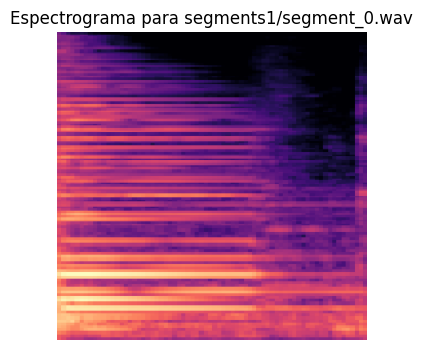

Reproduciendo: segments1/segment_1.wav


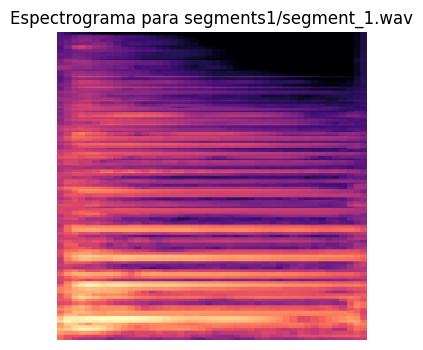

Reproduciendo: segments1/segment_2.wav


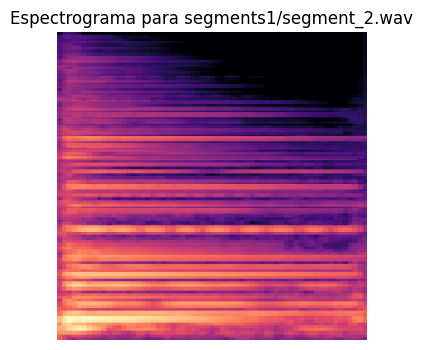

Reproduciendo: segments1/segment_3.wav


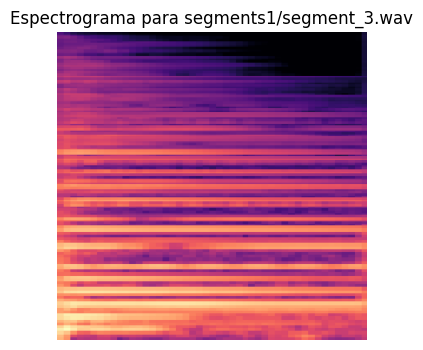

In [7]:
import matplotlib.pyplot as plt
for spectrogram_path in file_paths:
  file_path = spectrogram_path.replace('.png', '.wav')
  # Cargar el espectrograma como una imagen
  img = plt.imread(spectrogram_path)

  # Mostrar el archivo de audio
  print("Reproduciendo:", file_path)
  display(Audio(file_path))

  # Mostrar el espectrograma
  plt.figure(figsize=(10, 4))
  plt.imshow(img)
  plt.title(f'Espectrograma para {file_path}')
  plt.axis('off')  # Omitir los ejes para un aspecto más limpio
  plt.show()

# 4. Descargar modelos de TensorFlow
En este paso descargaremos los modelos previamente instalados para utilizarlos con los diferentes segmentos

In [8]:
import gdown
url = 'https://drive.google.com/uc?id=1QsAhzKn9kERBkjWmwzMhJ5vzi8c8mJni'
output = 'TensorFlowModels.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1QsAhzKn9kERBkjWmwzMhJ5vzi8c8mJni
From (redirected): https://drive.google.com/uc?id=1QsAhzKn9kERBkjWmwzMhJ5vzi8c8mJni&confirm=t&uuid=9da35d86-599c-4043-bc67-186b86b2caa2
To: /content/TensorFlowModels.zip
100%|██████████| 343M/343M [00:05<00:00, 62.3MB/s]


'TensorFlowModels.zip'

In [9]:
unzip_data("TensorFlowModels.zip")

1/1 [==============================] - 0s 110ms/step


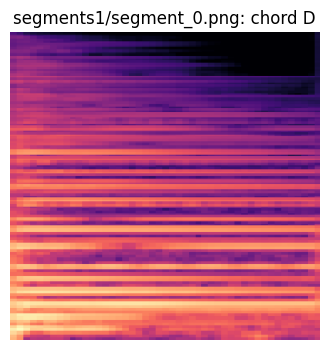

1/1 [==============================] - 0s 113ms/step


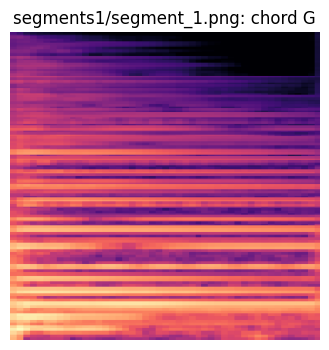

1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 106ms/step


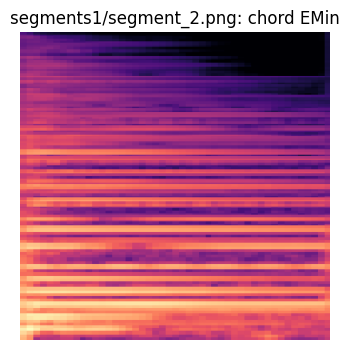

1/1 [==============================] - 0s 101ms/step


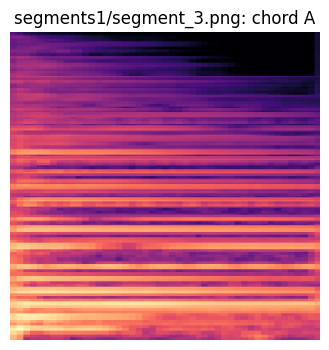

In [10]:
import tensorflow as tf
from keras.preprocessing import image
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

notes_classes = {'1_0': 0,
 '1_1': 1,
 '1_2': 2,
 '1_3': 3,
 '2_0': 4,
 '2_1': 5,
 '2_2': 6,
 '2_3': 7,
 '3_0': 8,
 '3_1': 9,
 '3_2': 10,
 '3_3': 11,
 '4_0': 12,
 '4_1': 13,
 '4_2': 14,
 '4_3': 15,
 '5_0': 16,
 '5_1': 17,
 '5_2': 18,
 '5_3': 19,
 '6_0': 20,
 '6_1': 21,
 '6_2': 22,
 '6_3': 23}

index_to_notes = {v: k for k, v in notes_classes.items()}

chords_classes = {'A': 0,
 'AMin': 1,
 'B': 2,
 'BMin': 3,
 'C': 4,
 'D': 5,
 'DMin': 6,
 'E': 7,
 'EMin': 8,
 'F': 9,
 'G': 10}

index_to_chords = {v: k for k, v in chords_classes.items()}

def load_spectogram_image(path):
    target_size=(224, 224)
    img = image.load_img(path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

def predict_chord_or_note(model_path, spectrogram):
    # Load the binary model to classify between chord and note
    chordvsnote_model = tf.keras.models.load_model(model_path + "chordvsnote.h5")


    # Predict if it's a chord or a note
    prediction = chordvsnote_model.predict(load_spectogram_image(spectrogram))
    is_chord = prediction[0][0] < 0.5

    if is_chord:
        classification = 'chord'
        # Load the chord model and predict
        chords_model = tf.keras.models.load_model(model_path + "chords.h5")
        chord_prediction = chords_model.predict(load_spectogram_image(spectrogram))
        chord_key = np.argmax(chord_prediction, axis=1)
        chord_name = index_to_chords[chord_key[0]]
        result = (classification, chord_name)
    else:
        classification = 'note'
        # Load the note model and predict
        notes_model = tf.keras.models.load_model(model_path + "notes.h5")
        note_prediction = notes_model.predict(load_spectogram_image(spectrogram))
        note_key = np.argmax(note_prediction, axis=1)
        note_name = index_to_notes[note_key[0]]
        result = (classification, note_name)

    return result

for spectrogram_path in file_paths:

  prediction = predict_chord_or_note("TensorFlowModels/", spectrogram_path)
  file_path = spectrogram_path.replace('.png', '.wav')
  display(Audio(file_path))
    # Mostrar el espectrograma
  plt.figure(figsize=(10, 4))
  plt.imshow(img)
  plt.title(f'{spectrogram_path}: {prediction[0]} {prediction[1]}')
  plt.axis('off')  # Omitir los ejes para un aspecto más limpio
  plt.show()
